# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configure visualizations
sns.set_style("darkgrid")

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
# Define a function to load data and aggregate them

def udf_aggregate_stock_data(file_paths, data_dir='.'):
    """
    Reads multiple stock CSV files, processes them, and merges them into a single DataFrame based on Date.

    Args:
        file_paths (list): A list of CSV file names (e.g., ['AMZN_stock_data.csv', ...]).
        data_dir (str): The directory where the CSV files are located.

    Returns:
        pandas.DataFrame: A single DataFrame containing the combined and processed stock data,
                          sorted by date. Returns None if the input list is empty.
    """
    all_data_frames = []
    stock_names = []

    if not file_paths:
        return None

    for file_name in file_paths:
        try:
            # extract stock name
            stock_name = file_name.split('_')[0]
            stock_names.append(stock_name)

            full_path = os.path.join(data_dir, file_name)

            # read the CSV, parse 'Date' column as datetime objects
            df = pd.read_csv(full_path, parse_dates=['Date'])

            df = df.drop(columns=['Name'])

            # rename columns (except 'Date') with the stock name prefix
            df = df.rename(columns={
                col: f"{stock_name}_{col}" for col in df.columns if col != 'Date'
            })

            # set 'Date' as the index for easier joining
            df = df.set_index('Date')

            all_data_frames.append(df)

        except FileNotFoundError:
            print(f"Warning: File not found at {full_path}. Skipping.")
        except Exception as e:
            print(f"Warning: Error processing file {file_name}: {e}. Skipping.")

    if not all_data_frames:
        print("Error: No dataframes were successfully loaded.")
        return None

    # concatenate all dataframes
    merged_df = pd.concat(all_data_frames, axis=1, join='inner')

    # sort by date index
    merged_df = merged_df.sort_index()

    print(f"Successfully merged data for stocks: {stock_names}")
    return merged_df


In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

# directory containing the data
data_directory = 'RNN_Stocks_Data' # Use the folder name you have

# files we need to process
stock_files = [
    'AMZN_stocks_data.csv',
    'GOOGL_stocks_data.csv',
    'IBM_stocks_data.csv',
    'MSFT_stocks_data.csv'
]

In [5]:
# read and combine the files
master_df = udf_aggregate_stock_data(stock_files, data_dir=data_directory)
master_df.shape

Successfully merged data for stocks: ['AMZN', 'GOOGL', 'IBM', 'MSFT']


(3019, 20)

In [6]:
# View specifics of the data

master_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AMZN_Open     3019 non-null   float64
 1   AMZN_High     3019 non-null   float64
 2   AMZN_Low      3019 non-null   float64
 3   AMZN_Close    3019 non-null   float64
 4   AMZN_Volume   3019 non-null   int64  
 5   GOOGL_Open    3019 non-null   float64
 6   GOOGL_High    3019 non-null   float64
 7   GOOGL_Low     3019 non-null   float64
 8   GOOGL_Close   3019 non-null   float64
 9   GOOGL_Volume  3019 non-null   int64  
 10  IBM_Open      3018 non-null   float64
 11  IBM_High      3019 non-null   float64
 12  IBM_Low       3018 non-null   float64
 13  IBM_Close     3019 non-null   float64
 14  IBM_Volume    3019 non-null   int64  
 15  MSFT_Open     3019 non-null   float64
 16  MSFT_High     3019 non-null   float64
 17  MSFT_Low      3019 non-null   float64
 18  MSFT_Close

In [7]:
master_df.head()

AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
Date                                                                  
2006-01-03      47.47      47.85     46.25       47.58      7582127   
2006-01-04      47.48      47.73     46.69       47.25      7440914   
2006-01-05      47.16      48.20     47.11       47.65      5417258   
2006-01-06      47.97      48.58     47.32       47.87      6154285   
2006-01-09      46.55      47.10     46.40       47.08      8945056   

            GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  GOOGL_Volume  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83      13137450   
2006-01-04      222.17      224.70     220.09       222.84      15292353   
2006-01-05      223.22      226.00     220.97       225.85      10815661   
2006-01-06      228.66      235.49     226.85       233.06      17759521   
2006-01-09      233.44      236.94     230.70       233.68      12795837   

            IBM_Open  IBM_High  IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  \
Date                                                                        
2006-01-03     82.45     82.55    80.81      82.06    11715200      26.25   
2006-01-04     82.20     82.50    81.33      81.95     9840600      26.77   
2006-01-05     81.40     82.90    81.00      82.50     7213500      26.96   
2006-01-06     83.95     85.03    83.41      84.95     8197400      26.89   
2006-01-09     84.10     84.25    83.38      83.73     6858200      26.93   

            MSFT_High  MSFT_Low  MSFT_Close  MSFT_Volume  
Date                                                      
2006-01-03      27.00     26.10       26.84     79974418  
2006-01-04      27.08     26.77       26.97     57975661  
2006-01-05      27.13     26.91       26.99     48247610  
2006-01-06      27.00     26.49       26.91    100969092  
2006-01-09      27.07     26.76       26.86     55627836

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [8]:
# Handle Missing Values

print("\nMissing values per column:")
print(master_df.isnull().sum())


Missing values per column:
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


In [9]:
# For time-series stock data, forward fill or backward fill is usually preferred. We will use ffill here - 

if master_df.isnull().any().any():
    print("\nMissing values found. Applying forward fill (ffill)...")
    master_df.ffill(inplace=True)  # Updated usage
    
    # check if ffill successful
    print("\nMissing values after forward fill:")
    print(master_df.isnull().sum())
else:
    print("\nNo missing values found in the merged data.")



Missing values found. Applying forward fill (ffill)...

Missing values after forward fill:
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [10]:
# Frequency distribution of volumes

stock_names = sorted(list(set([col.split('_')[0] for col in master_df.columns])))
stock_names


['AMZN', 'GOOGL', 'IBM', 'MSFT']

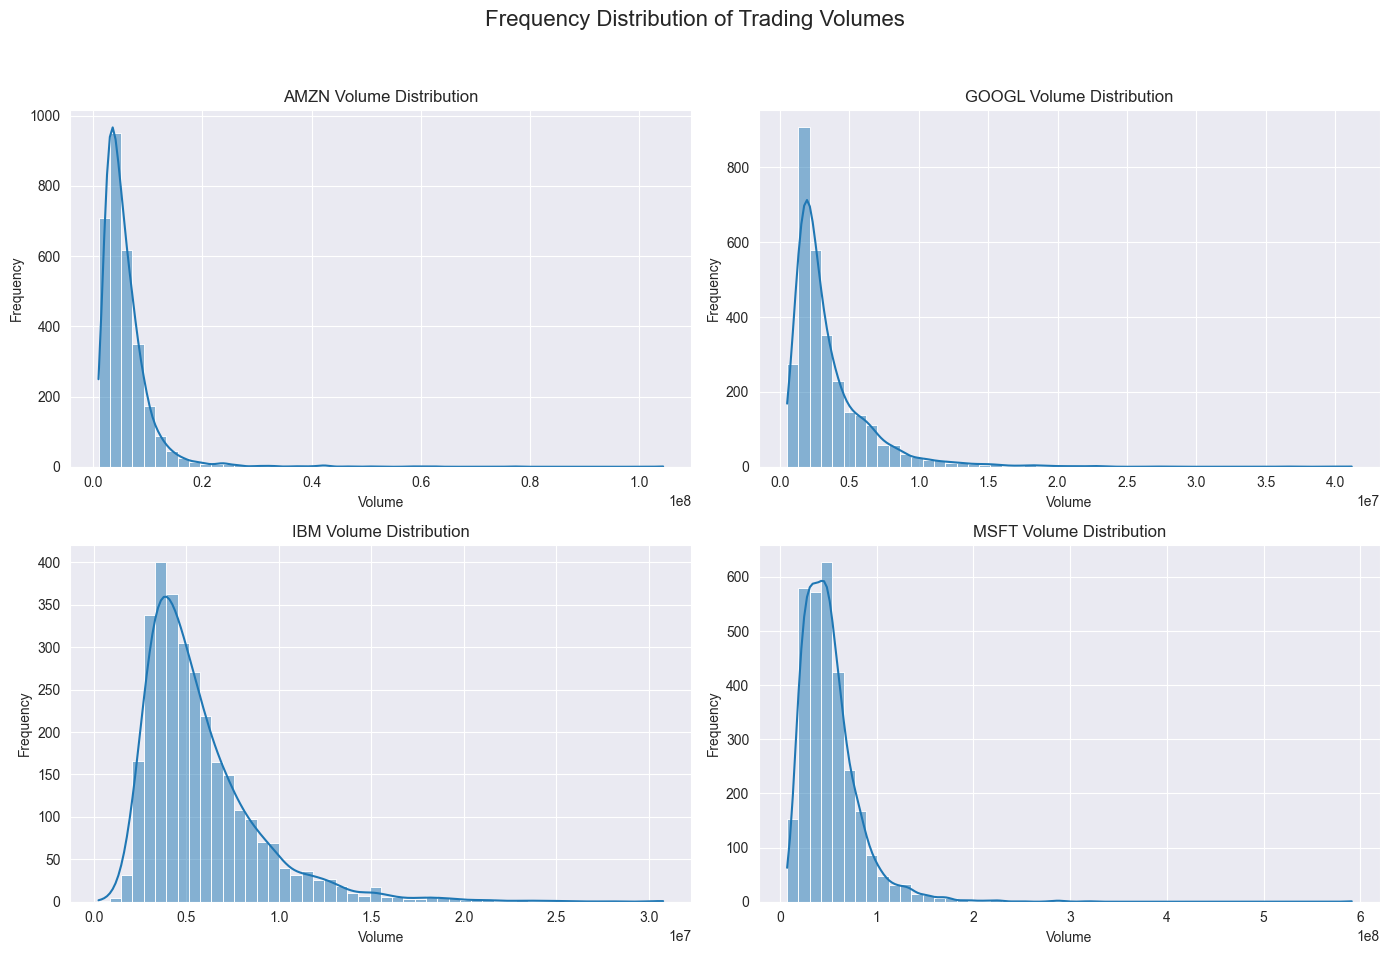

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

num_stocks = len(stock_names)
cols = 2  # number of cols in plot
rows = math.ceil(num_stocks / cols)

# create subplots
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
fig.suptitle("Frequency Distribution of Trading Volumes", fontsize=16)
axes = axes.flatten()  # Flatten in case of 2D grid

# plot each stock
for i, stock in enumerate(stock_names):
    volume_col = f"{stock}_Volume"
    if volume_col in master_df.columns:
        sns.histplot(master_df[volume_col], kde=True, bins=50, ax=axes[i])
        axes[i].set_title(f"{stock} Volume Distribution")
        axes[i].set_xlabel("Volume")
        axes[i].set_ylabel("Frequency")

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



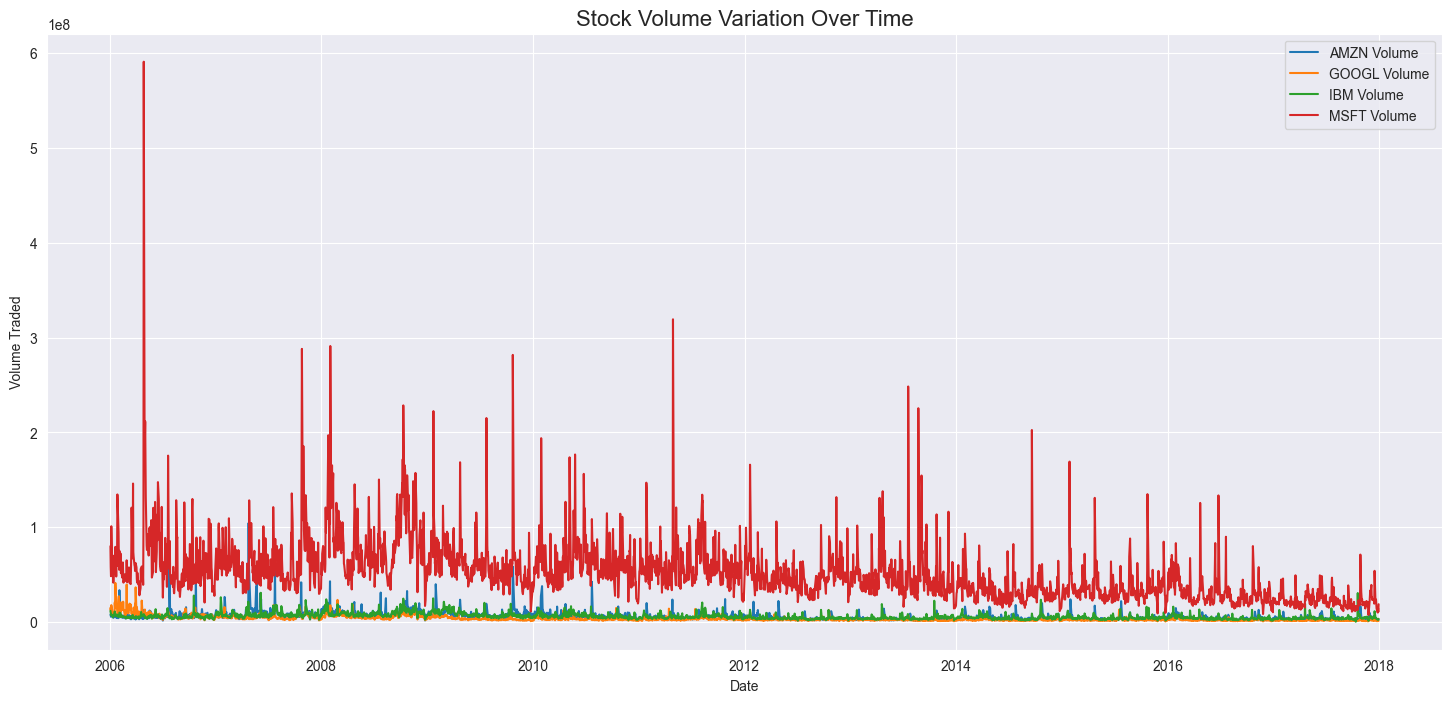

In [12]:
# Stock volume variation over time

plt.figure(figsize=(18, 8))
plt.title("Stock Volume Variation Over Time", fontsize=16)

for stock in stock_names:
    volume_col = f"{stock}_Volume"
    if volume_col in master_df.columns:
        plt.plot(master_df.index, master_df[volume_col], label=f"{stock} Volume")

plt.xlabel("Date")
plt.ylabel("Volume Traded")
plt.legend()
plt.show()

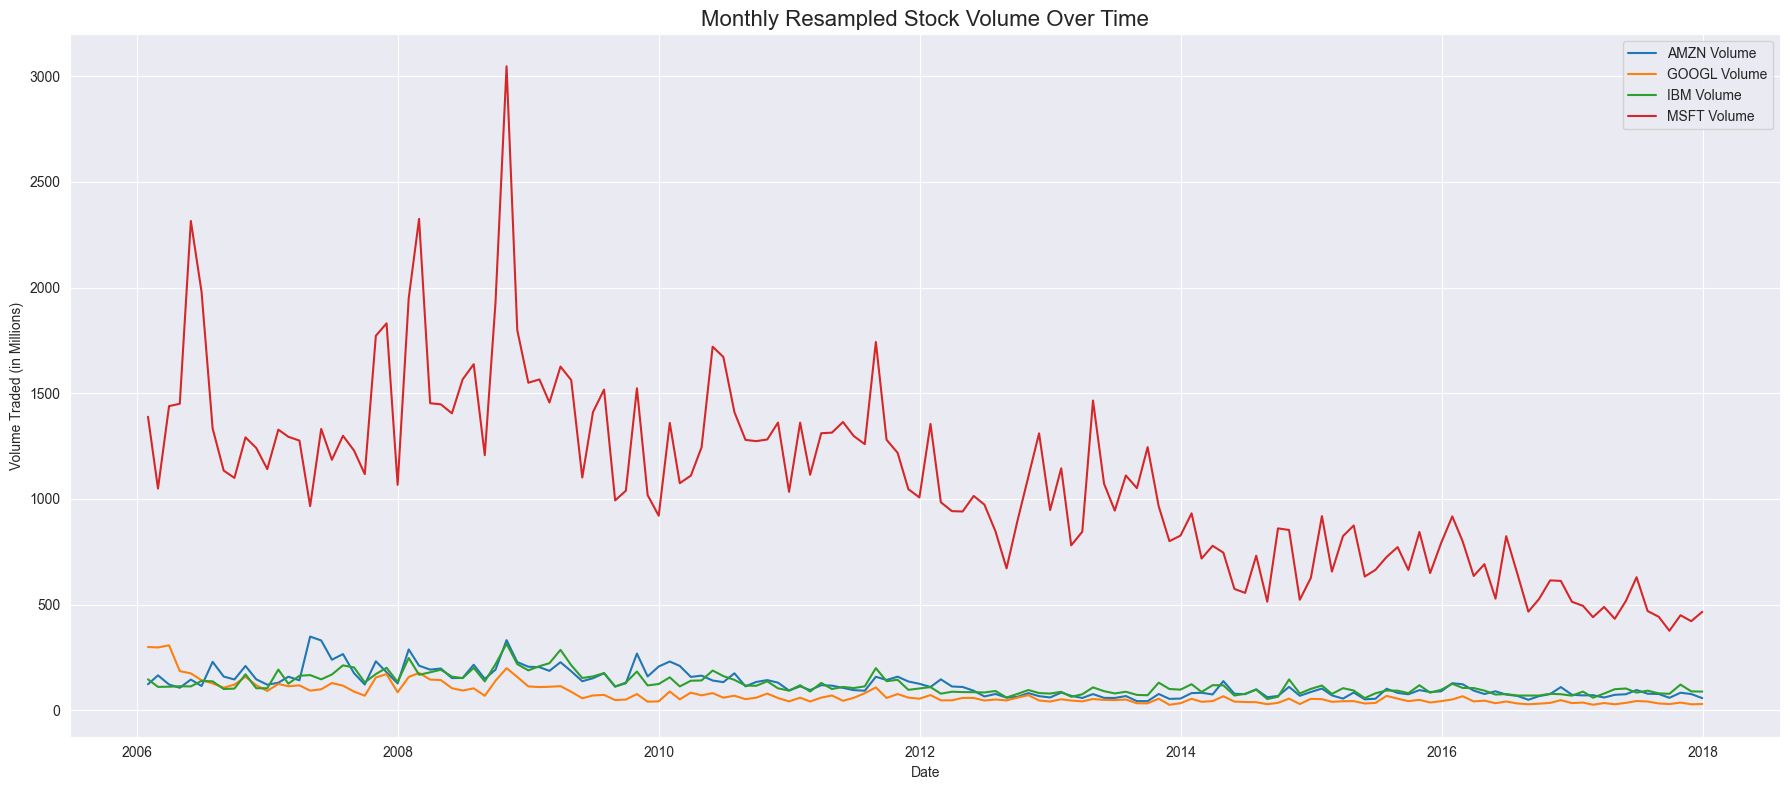

In [13]:
# Resampled to Monthly timeframe and scaled in terms of millions
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))
plt.title("Monthly Resampled Stock Volume Over Time", fontsize=16)

for stock in stock_names:
    volume_col = f"{stock}_Volume"
    if volume_col in master_df.columns:
        # monthly resample
        monthly_volume = master_df[volume_col].resample('ME').sum()
        plt.plot(monthly_volume.index, monthly_volume / 1_000_000, label=f"{stock} Volume")

plt.xlabel("Date")
plt.ylabel("Volume Traded (in Millions)")  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

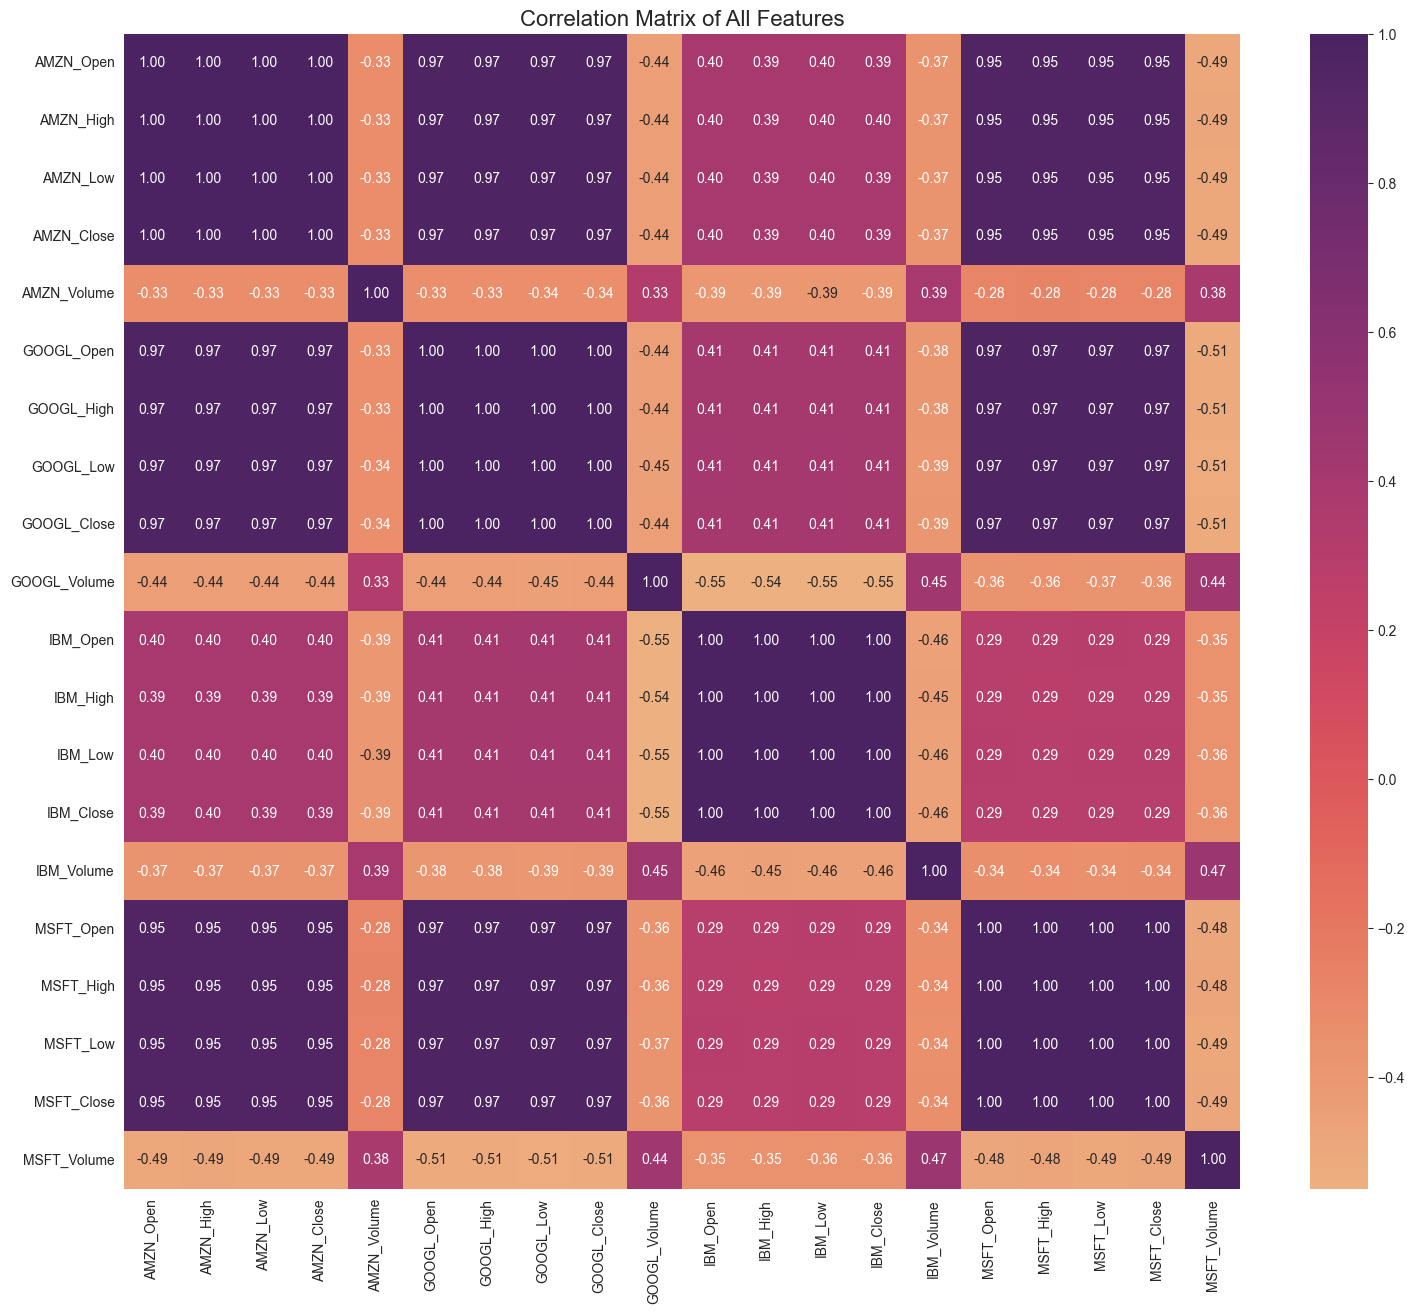

In [14]:
# Analyse correlations

correlation_matrix = master_df.corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(18, 15)) 
sns.heatmap(correlation_matrix, cmap='flare', annot=True, fmt=".2f")
plt.title("Correlation Matrix of All Features", fontsize=16)
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [15]:
# Define a function that divides the data into windows and generates target variable values for each window

def udf_create_windows_as_list(data, window_size, window_stride, target_columns):
    """
    Creates input windows (X) and corresponding target values (y) from time series data.
    
    Each window consists of `window_size` consecutive rows from the dataset, and the target
    is the value(s) immediately following that window, from the specified `target_columns`.
    
    Args:
        data (pd.DataFrame): The time series data with features as columns and time-indexed rows.
        window_size (int): Number of time steps (rows) in each input window.
        window_stride (int): Number of steps to skip when sliding the window forward.
        target_columns (list): List of column names to extract as targets (y values).
    
    Returns:
        tuple: (X_windows, y_targets)
            - X_windows: List of DataFrames, each of shape (window_size, num_features)
            - y_targets: List of Series or values, each corresponding to the target(s) for one window
    """
    
    X_windows, y_targets = [], []

    # Slide the window over the dataset
    for i in range(0, len(data) - window_size, window_stride):
        end = i + window_size          # exclusive end of the window
        target_index = end            # target is the row immediately after the window

        # break loop if we're at the end
        if target_index >= len(data):
            break

        # extract the window of input features (rows i to end-1)
        X_windows.append(data.iloc[i:end])

        # extract the target values from the row right after the window
        y_targets.append(data.iloc[target_index][target_columns])

    return X_windows, y_targets


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [16]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def udf_scale_windowed_data(X_windows_list, y_targets_list, scaler, target_columns):
    """
    Scales the windowed input (X) and target (y) data using a pre-fitted scaler.

    Parameters:
        X_windows_list (list): List of DataFrames for each input window.
        y_targets_list (list): List of Series/values for corresponding targets.
        scaler (sklearn.preprocessing.Scaler): A scaler object already fitted on the training data.
        target_columns (list): List of column names for the target variables.

    Returns:
        tuple: (X_scaled_list, y_scaled_list)
            - X_scaled_list (list): List of NumPy arrays for each scaled input window.
            - y_scaled_list (list): List of NumPy arrays for each scaled target.
        Returns (None, None) if inputs are invalid.
    """
    # input validation
    if not (X_windows_list and y_targets_list and scaler and target_columns):
        print("Error: Invalid inputs to scale_windowed_data.")
        return None, None

    X_scaled_list = []
    y_scaled_list = []

    # assume the feature order is as provided in the first window
    feature_names = X_windows_list[0].columns.tolist()

    # identify the column indices for the target variables
    try:
        target_indices = [feature_names.index(col) for col in target_columns]
    except ValueError as e:
        print(f"Error: A target column is missing in the feature list: {e}")
        return None, None

    # scale each input window
    for window_df in X_windows_list:
        # ensure the columns are in the correct order before scaling
        window_df_ordered = window_df[feature_names]
        X_scaled_list.append(scaler.transform(window_df_ordered))

    # scale each target by placing its value in a dummy row
    num_features = len(feature_names)
    for target in y_targets_list:
        # Ensure target is a pandas Series
        if not isinstance(target, pd.Series):
            target = pd.Series(target, index=target_columns)

        # create a dummy row with zeros
        dummy_row = np.zeros((1, num_features))

        # insert each target value into its corresponding column position
        for idx, col in zip(target_indices, target_columns):
            dummy_row[0, idx] = target[col]

        # Convert dummy row to a DataFrame with feature names before transforming
        dummy_df = pd.DataFrame(dummy_row, columns=feature_names)
        scaled_dummy = scaler.transform(dummy_df)
        # Extract the scaled target values using their original indices
        scaled_target = scaled_dummy[0, target_indices]
        y_scaled_list.append(scaled_target)

    print(f"Scaled {len(X_scaled_list)} windows and {len(y_scaled_list)} targets.")
    return X_scaled_list, y_scaled_list


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame

def udf_process_data_for_rnn(data, target_columns, window_size, window_stride, test_split_ratio, random_state=42):
    """
    Processes the master DataFrame for RNN input by windowing, scaling, and splitting.

    Args:
        data (pd.DataFrame): The master DataFrame with time-indexed stock data.
        target_columns (list): List of column names to predict (e.g., ['AMZN_Close', 'GOOGL_Close']).
        window_size (int): The number of time steps in each input sequence (window).
        window_stride (int): The step size to move the window forward.
        test_split_ratio (float): The proportion of the data to use for the test set (e.g., 0.2 for 20%).
        random_state (int): Random seed for reproducibility of the train-test split.

    Returns:
        tuple: (X_train, y_train, X_test, y_test, scaler)
            - X_train (np.ndarray): Scaled training input sequences. Shape: (n_samples, window_size, n_features).
            - y_train (np.ndarray): Scaled training target values. Shape: (n_samples, n_targets).
            - X_test (np.ndarray): Scaled testing input sequences. Shape: (n_samples, window_size, n_features).
            - y_test (np.ndarray): Scaled testing target values. Shape: (n_samples, n_targets).
            - scaler (MinMaxScaler): The scaler fitted on the training data (useful for inverse transform).
        Returns (None, None, None, None, None) if processing fails.
    """
    print(f"Starting data processing with window_size={window_size}, stride={window_stride}, test_split={test_split_ratio}")

    print("Creating windows...")
    X_windows_list, y_targets_list = udf_create_windows_as_list(data, window_size, window_stride, target_columns)

    if not X_windows_list:
        print("Error: No windows were created. Check data length and window parameters.")
        return None, None, None, None, None

    print(f"Created {len(X_windows_list)} windows.")

    # splitting the lists of windows before scaling to prevent data leakage
    print("Splitting data into training and testing sets...")
    try:
        X_train_list, X_test_list, y_train_list, y_test_list = train_test_split(
            X_windows_list, y_targets_list, test_size=test_split_ratio, random_state=random_state, shuffle=False
            # IMPORTANT: shuffle=False is crucial for time series data to maintain order
        )
    except ValueError as e:
         print(f"Error during train-test split: {e}. Not enough samples?")
         print(f"Total windows: {len(X_windows_list)}, Test ratio: {test_split_ratio}")
         return None, None, None, None, None


    print(f"Training windows: {len(X_train_list)}, Testing windows: {len(X_test_list)}")

    # scale the data
    scaler = MinMaxScaler() 

    # fit the scaler ONLY on the training data features (X)
    # to fit properly, we need to temporarily combine the training windows' data
    print("Fitting scaler on training data...")
    temp_train_df = pd.concat(X_train_list, axis=0) # Stack all training windows vertically
    scaler.fit(temp_train_df)
    print("Scaler fitted.")

    # use FITTED scaler to transform both training and testing data
    print("Scaling training data...")
    X_train_scaled_list, y_train_scaled_list = udf_scale_windowed_data(X_train_list, y_train_list, scaler, target_columns)

    print("Scaling testing data...")
    X_test_scaled_list, y_test_scaled_list = udf_scale_windowed_data(X_test_list, y_test_list, scaler, target_columns)

    if X_train_scaled_list is None or X_test_scaled_list is None:
        print("Error during scaling process.")
        return None, None, None, None, None

    # convert the lists of scaled windows/targets into NumPy arrays
    # X shape: (number of windows, window_size, number of features)
    # y shape: (number of windows, number of target variables)
    print("Converting lists to NumPy arrays...")
    try:
        X_train = np.array(X_train_scaled_list)
        y_train = np.array(y_train_scaled_list)
        X_test = np.array(X_test_scaled_list)
        y_test = np.array(y_test_scaled_list)
    except Exception as e:
        print(f"Error converting lists to NumPy arrays: {e}")
        # inspect list contents here if this fails
        return None, None, None, None, None

    print("Data processing complete.")
    return X_train, y_train, X_test, y_test, scaler

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

Analyzing patterns for: AMZN_Close


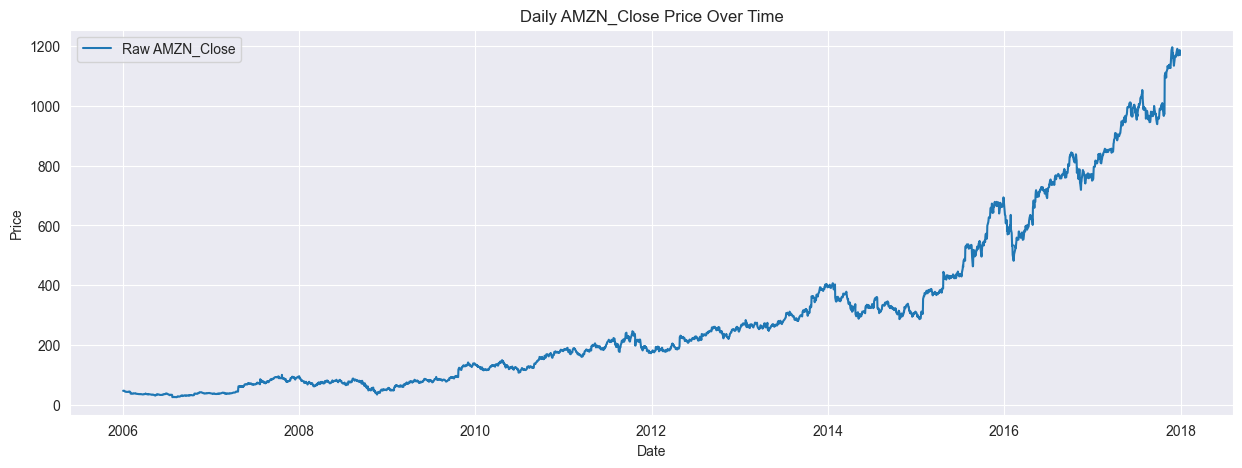

In [18]:
# Checking for patterns in different sequence lengths


# Let's take a look at AMZN price
target_analyze_col = 'AMZN_Close'
print(f"Analyzing patterns for: {target_analyze_col}")

# 1. Visual Inspection of Raw Data
plt.figure(figsize=(15, 5))
plt.plot(master_df.index, master_df[target_analyze_col], label=f'Raw {target_analyze_col}')
plt.title(f'Daily {target_analyze_col} Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

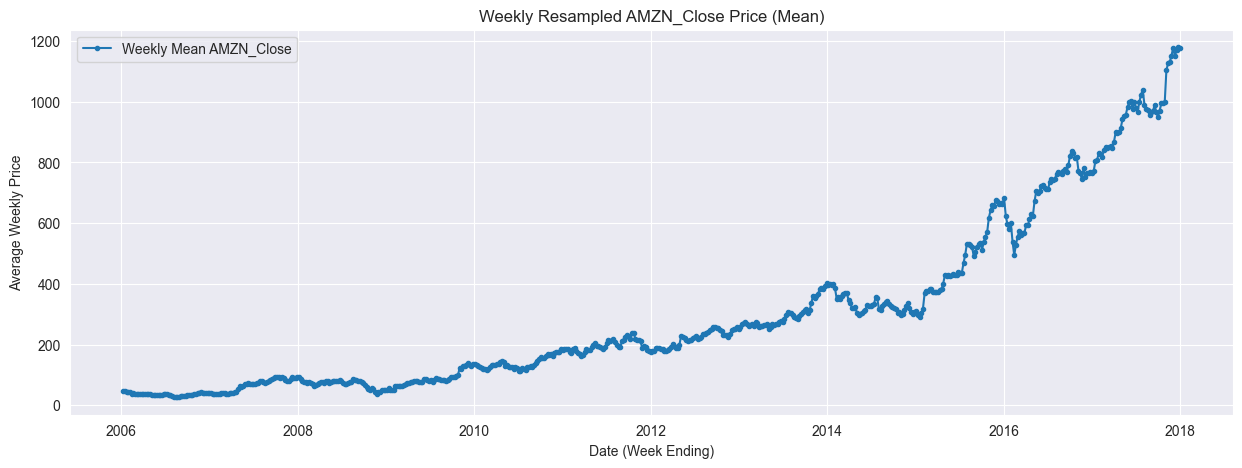

In [19]:
# Resample to Weekly frequency (taking the mean price for each week)
# 'W' stands for weekly frequency, ending on Sunday by default.
weekly_data = master_df[target_analyze_col].resample('W').mean()
plt.figure(figsize=(15, 5))
plt.plot(weekly_data.index, weekly_data, label=f'Weekly Mean {target_analyze_col}', marker='.', linestyle='-')
plt.title(f'Weekly Resampled {target_analyze_col} Price (Mean)')
plt.xlabel('Date (Week Ending)')
plt.ylabel('Average Weekly Price')
plt.legend()
plt.grid(True)
plt.show()

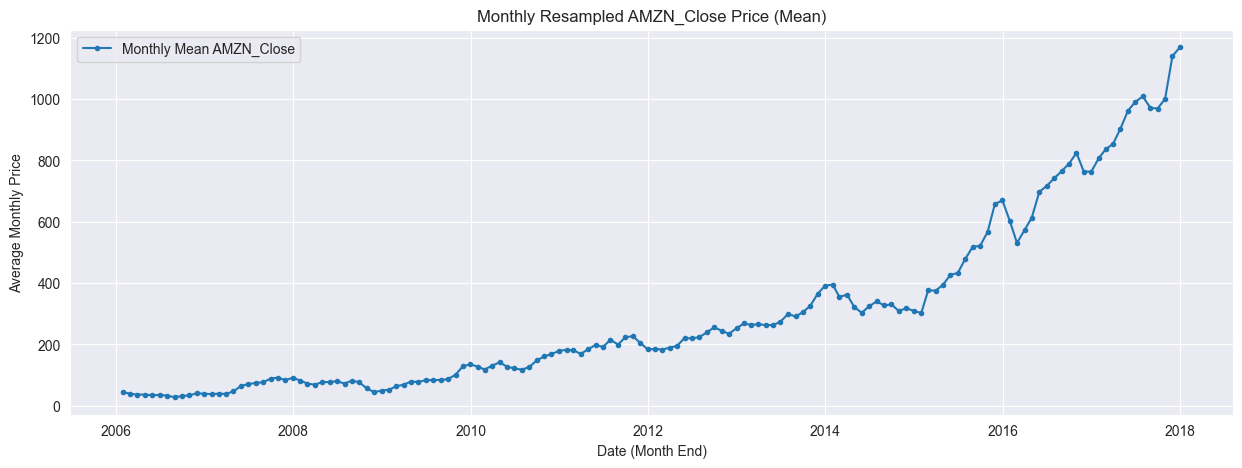

In [20]:
# Resample to Monthly frequency (taking the mean price for each month end)
# 'ME' stands for Month End frequency.
monthly_data = master_df[target_analyze_col].resample('ME').mean()
plt.figure(figsize=(15, 5))
plt.plot(monthly_data.index, monthly_data, label=f'Monthly Mean {target_analyze_col}', marker='.', linestyle='-')
plt.title(f'Monthly Resampled {target_analyze_col} Price (Mean)')
plt.xlabel('Date (Month End)')
plt.ylabel('Average Monthly Price')
plt.legend()
plt.grid(True)
plt.show()

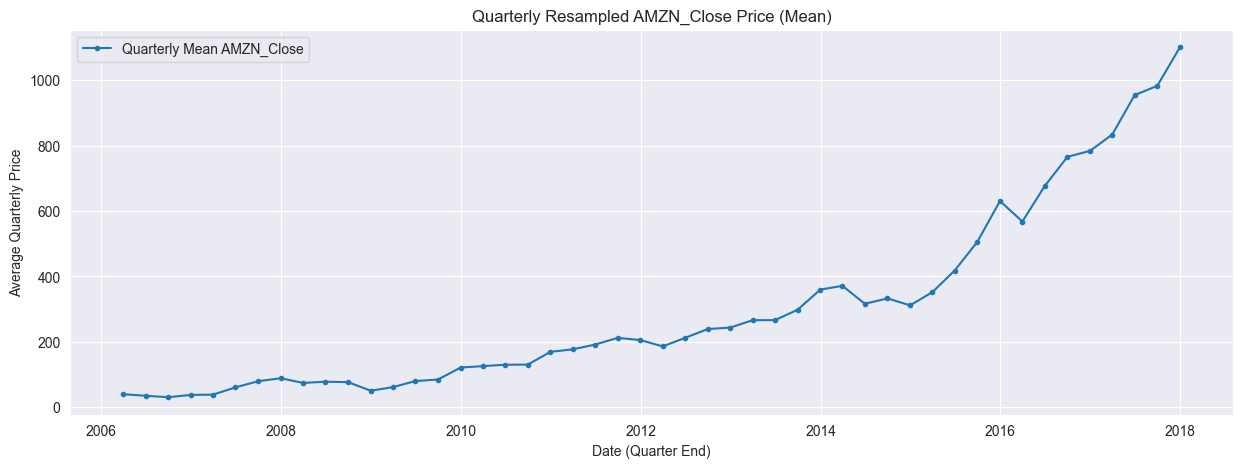

In [21]:
# 'QE' stands for Quarter End frequency.
quarterly_data = master_df[target_analyze_col].resample('QE').mean()
plt.figure(figsize=(15, 5))
plt.plot(quarterly_data.index, quarterly_data, label=f'Quarterly Mean {target_analyze_col}', marker='.', linestyle='-')
plt.title(f'Quarterly Resampled {target_analyze_col} Price (Mean)')
plt.xlabel('Date (Quarter End)')
plt.ylabel('Average Quarterly Price')
plt.legend()
plt.grid(True)
plt.show()

>- Daily AMZN_Close Price: Shows the daily data with its inherent volatility and the overall upward trend.
>- Weekly Resampled Price: Smooths out some of the daily noise, making weekly trends and fluctuations slightly clearer.
>- Monthly Resampled Price: Further smoothing, highlighting the broader monthly movements and cycles.
>- Quarterly Resampled Price: Provides the most smoothed view, emphasizing the long-term trend and significant shifts occurring over quarterly periods.

> **Analysis and Window Size Selection:**

*   **Visual Inspection:** The raw price shows a strong upward trend with considerable noise/fluctuations.
*   **Resampled Plots:** The weekly, monthly, and quarterly plots smooth out the daily noise. The monthly plot clearly shows significant price movements and cycles occurring over monthly intervals, which are less apparent in the daily data but less smoothed than the quarterly view.
*   **Business Context:** While quarterly earnings are important, many economic indicators and market adjustments happen on a monthly cadence. Using a monthly window might allow the model to better capture these shorter-term dynamics.

> **Decision:**
Based on the monthly resampled plot showing distinct patterns over monthly periods and considering the relevance of monthly cycles in market behavior, we will choose a window size corresponding to approximately one business month.
-   Approx. Trading Days per Month: 21 days (can vary slightly)

We will choose a window size of **21 trading days**.

In [22]:
# chosen window size based on the analysis
chosen_window_size = 21 # represents ~1 business month in trading days
print(f"Chosen window size based on visual analysis and business context: {chosen_window_size} days")

Chosen window size based on visual analysis and business context: 21 days


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [23]:
# Create data instances from the master data frame using decided window size and window stride

target_variable_names = ['AMZN_Close']
window_size = chosen_window_size      # defined as 21 earlier
window_stride = 5
test_fraction = 0.20
random_seed = 42


print(f"--- Preparing Data Using udf_process_data_for_rnn ---")
print(f"Target variable(s): {target_variable_names}")
print(f"Window size (timesteps): {window_size}")
print(f"Window stride: {window_stride}")
print(f"Test set fraction: {test_fraction}")

--- Preparing Data Using udf_process_data_for_rnn ---
Target variable(s): ['AMZN_Close']
Window size (timesteps): 21
Window stride: 5
Test set fraction: 0.2


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, y_train, X_test, y_test, data_scaler = udf_process_data_for_rnn(
    data=master_df,
    target_columns=target_variable_names,
    window_size=window_size,
    window_stride=window_stride,
    test_split_ratio=test_fraction,
    random_state=random_seed
)

print("\nFinished calling udf_process_data_for_rnn.")

Starting data processing with window_size=21, stride=5, test_split=0.2
Creating windows...
Created 600 windows.
Splitting data into training and testing sets...
Training windows: 480, Testing windows: 120
Fitting scaler on training data...
Scaler fitted.
Scaling training data...
Scaled 480 windows and 480 targets.
Scaling testing data...
Scaled 120 windows and 120 targets.
Converting lists to NumPy arrays...
Data processing complete.

Finished calling udf_process_data_for_rnn.


In [25]:
# Check the number of data points generated


if 'X_train' in locals() and X_train is not None:
    print("\n--- Generated Dataset Shapes ---")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")


    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    num_features = X_train.shape[2]
    num_targets = y_train.shape[1] if y_train.ndim > 1 else 1
    print(f"\nNumber of features per time step (Input): {num_features}")
    print(f"Number of target variables (Output): {num_targets}")
    print(f"Scaler used: {type(data_scaler).__name__}")

else:
    print("\nData generation seems to have failed in the previous step.")
    print("Cannot display shapes as X_train, y_train, etc. might not exist.")


--- Generated Dataset Shapes ---
X_train shape: (480, 21, 20)
y_train shape: (480, 1)
X_test shape: (120, 21, 20)
y_test shape: (120, 1)

Number of features per time step (Input): 20
Number of target variables (Output): 1
Scaler used: MinMaxScaler


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks
print("\n--- RNN Data Compatibility Check ---")

# Check data shapes
print(f"X_train: {X_train.shape}")  # should be (samples, time steps, features)
print(f"y_train: {y_train.shape}")  # should be (samples, target variables)
print(f"X_test: {X_test.shape}")    # same structure as X_train
print(f"y_test: {y_test.shape}")    # same structure as y_train

# Quick validation
if X_train.ndim == 3 and y_train.shape[0] == X_train.shape[0]:
    print("Data format is compatible with RNN models")
else:
    print("Data format issues detected - RNNs require 3D input tensors (samples, timesteps, features)")


--- RNN Data Compatibility Check ---
X_train: (480, 21, 20)
y_train: (480, 1)
X_test: (120, 21, 20)
y_test: (120, 1)
Data format is compatible with RNN models


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def udf_build_simple_rnn_model(input_shape, output_shape, rnn_units=64, dense_units=32, 
                             dropout_rate=0.2, learning_rate=0.001):
    """
    Creates a simple RNN model with the specified configuration.
    
    Args:
        input_shape (tuple): Shape of input data (time steps, features).
        output_shape (int): Number of output units (target variables to predict).
        rnn_units (int): Number of neurons in the SimpleRNN layer.
        dense_units (int): Number of neurons in the Dense layer.
        dropout_rate (float): Dropout rate to prevent overfitting.
        learning_rate (float): Learning rate for the Adam optimizer.
    
    Returns:
        tf.keras.Model: A compiled simple RNN model.
    """
    # input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # RNN layer
    x = tf.keras.layers.SimpleRNN(units=rnn_units, activation='tanh', return_sequences=False)(inputs)
    
    # dropout layer to prevent overfitting
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # dense layer
    x = tf.keras.layers.Dense(units=dense_units, activation='relu')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(output_shape, activation='linear')(x)
    
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # compile model with Adam optimizer and MSE loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN
from sklearn.model_selection import ParameterGrid
import time

# Define the hyperparameter grid to search
param_grid = {
    'rnn_units': [32, 64, 128],
    'dense_units': [16, 32],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [30]  # Fixed number of epochs for all runs
}

# create all possible combinations of hyperparameters
hyperparameter_combinations = list(ParameterGrid(param_grid))
print(f"Total number of combinations: {len(hyperparameter_combinations)}")

# initialize lists to store results
results = []

# define input shape based on our data
time_steps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1] if len(y_train.shape) > 1 else 1

# Train and evaluate models with different hyperparameter combinations
for i, params in enumerate(hyperparameter_combinations):
    print(f"\nTraining model {i+1}/{len(hyperparameter_combinations)}")
    print(f"Parameters: {params}")
    
    # build model with current parameters
    model = udf_build_simple_rnn_model(
        input_shape=(time_steps, n_features),
        output_shape=n_outputs,
        rnn_units=params['rnn_units'],
        dense_units=params['dense_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    # start timer
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    
    # calculate training time
    training_time = time.time() - start_time
    
    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # store results
    results.append({
        'params': params,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'training_time': training_time,
        'history': history.history
    })
    
    print(f"Test loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Training time: {training_time:.2f}s")
    
    # clear backend session to free memory
    tf.keras.backend.clear_session()

Total number of combinations: 48

Training model 1/48
Parameters: {'batch_size': 16, 'dense_units': 16, 'dropout_rate': 0.2, 'epochs': 30, 'learning_rate': 0.001, 'rnn_units': 32}
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0972 - mean_absolute_error: 0.2439 - val_loss: 0.1770 - val_mean_absolute_error: 0.4037
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - mean_absolute_error: 0.0929 - val_loss: 0.1478 - val_mean_absolute_error: 0.3640
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - mean_absolute_error: 0.0795 - val_loss: 0.1315 - val_mean_absolute_error: 0.3405
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0086 - mean_absolute_error: 0.0683 - val_loss: 0.1232 - val_mean_absolute_error: 0.3293
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051 - mean_absolute_error: 0.0549 - val_loss: 0.1041 - val_mean_absolute_error: 0.3001
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062 - mean_abso

In [29]:
# Find the best configuration based on evaluation metrics
import pandas as pd

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame([
    {
        'rnn_units': r['params']['rnn_units'],
        'dense_units': r['params']['dense_units'],
        'dropout_rate': r['params']['dropout_rate'],
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'test_loss': r['test_loss'],
        'test_mae': r['test_mae'],
        'training_time': r['training_time']
    } for r in results
])

# Sort by test loss (lower is better)
results_df_sorted = results_df.sort_values('test_loss')
print("Top 5 models by test loss:")
print(results_df_sorted.head(5))

# Get the best configuration
best_params = results_df_sorted.iloc[0].to_dict()
print("\nBest model configuration:")
for param, value in best_params.items():
    if param not in ['test_loss', 'test_mae', 'training_time']:
        print(f"{param}: {value}")

print(f"\nBest model metrics:")
print(f"Test Loss (MSE): {best_params['test_loss']:.6f}")
print(f"Test MAE: {best_params['test_mae']:.6f}")
print(f"Training Time: {best_params['training_time']:.2f} seconds")

Top 5 models by test loss:
    rnn_units  dense_units  dropout_rate  learning_rate  batch_size  \
2         128           16           0.2          0.001          16   
13         64           32           0.2          0.001          16   
38        128           32           0.2          0.001          32   
8         128           16           0.3          0.001          16   
15         32           32           0.2          0.010          16   

    test_loss  test_mae  training_time  
2    0.212936  0.433015      10.533900  
13   0.309233  0.502887      10.170940  
38   0.353872  0.539179       9.121405  
8    0.396513  0.573658       8.673378  
15   0.423578  0.585971      11.001705  

Best model configuration:
rnn_units: 128.0
dense_units: 16.0
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 16.0

Best model metrics:
Test Loss (MSE): 0.212936
Test MAE: 0.433015
Training Time: 10.53 seconds


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

Training final model with optimal hyperparameters:
rnn_units: 128
dense_units: 16
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 16
epochs: 50
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2535 - mean_absolute_error: 0.2883 - val_loss: 0.0667 - val_mean_absolute_error: 0.2378 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065 - mean_absolute_error: 0.0621 - val_loss: 0.0625 - val_mean_absolute_error: 0.2286 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mean_absolute_error: 0.0515 - val_loss: 0.0742 - val_mean_absolute_error: 0.2541 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0410 - val_loss: 0.0603 - val_mean_absolute_error: 0.2258 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - mean_absolute_error: 0.0407 - val_loss: 0.0529 - val_mean_absolute_error: 0.2101 - learning_rate:

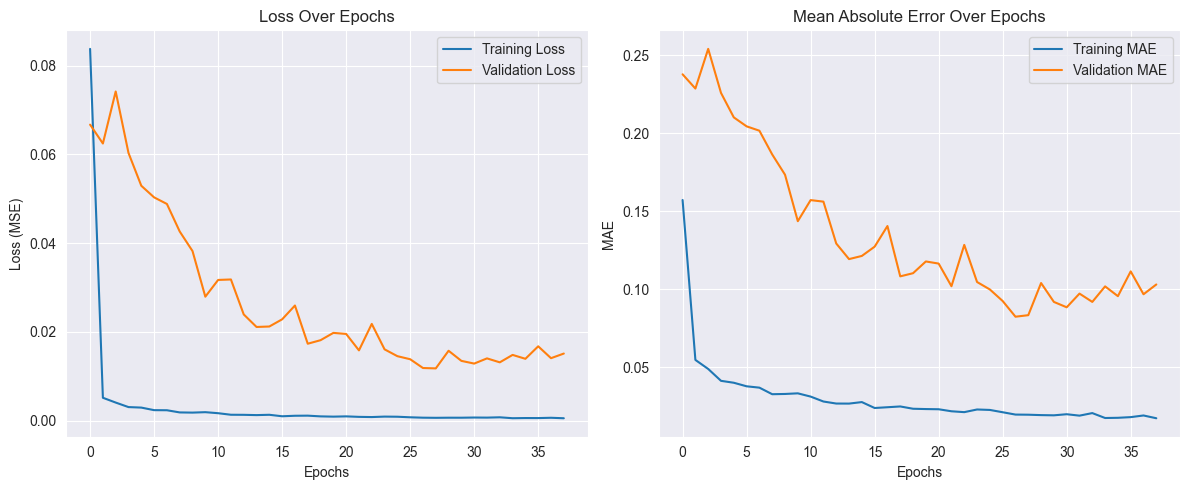

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
# Define the optimal hyperparameters (use the best ones found from hyperparameter tuning)
optimal_params = {
    'rnn_units': int(best_params['rnn_units']),
    'dense_units': int(best_params['dense_units']),
    'dropout_rate': best_params['dropout_rate'],
    'learning_rate': best_params['learning_rate'],
    'batch_size': int(best_params['batch_size']),
    'epochs': 50  # Let's train for more epochs with the best configuration
}

print("Training final model with optimal hyperparameters:")
for param, value in optimal_params.items():
    print(f"{param}: {value}")

# build the model with optimal hyperparameters
time_steps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1] if len(y_train.shape) > 1 else 1

tf.keras.backend.clear_session()


final_simple_rnn_model = udf_build_simple_rnn_model(
    input_shape=(time_steps, n_features),
    output_shape=n_outputs,
    rnn_units=optimal_params['rnn_units'],
    dense_units=optimal_params['dense_units'],
    dropout_rate=optimal_params['dropout_rate'],
    learning_rate=optimal_params['learning_rate']
)

# define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001
    )
]

# train the model
final_history = final_simple_rnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=optimal_params['epochs'],
    batch_size=optimal_params['batch_size'],
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_history.history['mean_absolute_error'], label='Training MAE')
plt.plot(final_history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

Plotting the actual vs predicted values

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Shape of y_test (scaled): (120, 1)
Shape of y_pred_scaled: (120, 1)
Original indices of target columns: [3]


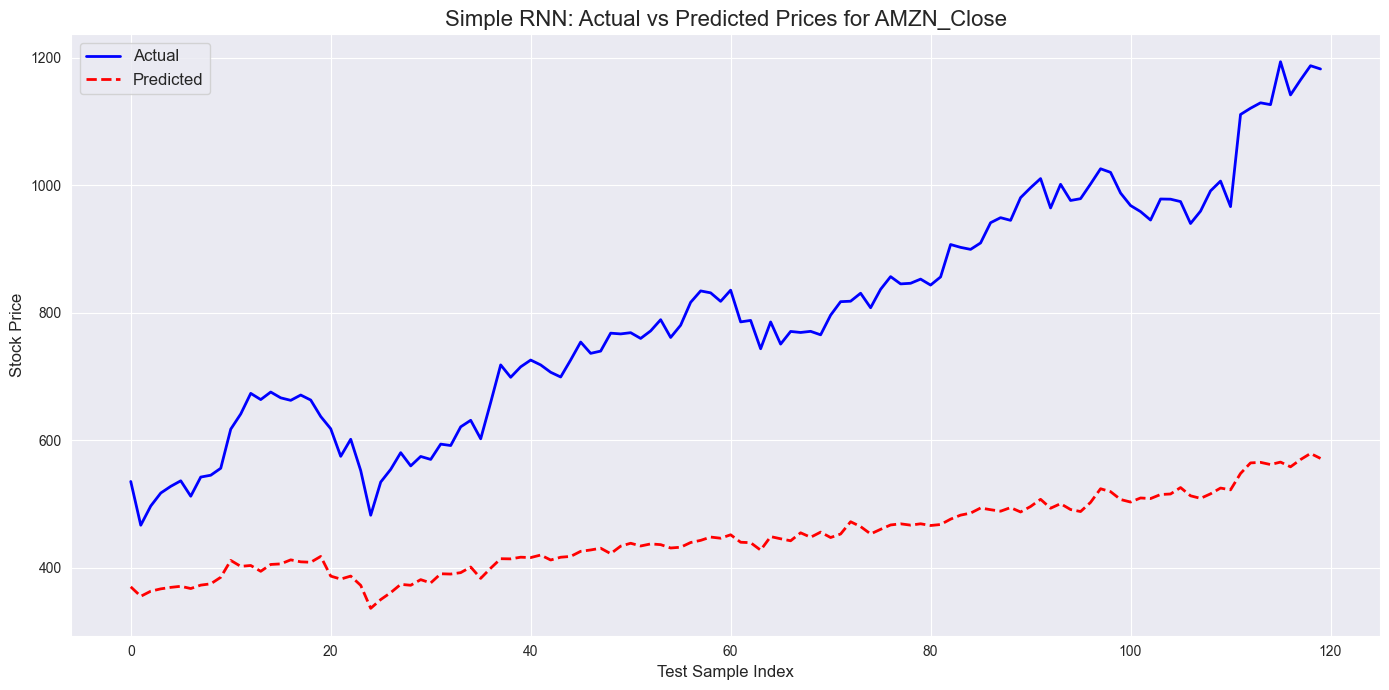

In [ ]:
# Predict on the test data and plot

# Make predictions
y_pred_scaled = final_simple_rnn_model.predict(X_test)

# check shapes
print(f"Shape of y_test (scaled): {y_test.shape}") # Should be (num_test_samples, num_targets)
print(f"Shape of y_pred_scaled: {y_pred_scaled.shape}") # Should be (num_test_samples, num_targets)

# inverse transform the predictions and the actual test values
# need to create dummy arrays with the original number of features
# to use the scaler's inverse_transform method correctly.

original_feature_count = X_train.shape[2] # Number of features scaler was trained on
num_test_samples = len(y_test)
num_targets = y_test.shape[1]

# ceate arrays of zeros with original feature structure
y_test_full_structure = np.zeros((num_test_samples, original_feature_count))
y_pred_full_structure = np.zeros((num_test_samples, original_feature_count))

# find the column indices of the target variable(s) in the original master_df
all_feature_names = master_df.columns.tolist()
target_indices = []
for target_col in target_variable_names:
    try:
        target_indices.append(all_feature_names.index(target_col))
    except ValueError:
        print(f"Error: Target column '{target_col}' not found in master_df columns.")
        raise ValueError(f"Target column '{target_col}' mismatch.")

print(f"Original indices of target columns: {target_indices}")

# place the scaled target values into the correct columns of the dummy arrays
for i, original_idx in enumerate(target_indices):
    # y_test[:, i] fetches the i-th target column from y_test
    # needs to be assigned to the column 'original_idx' in the full structure array
    y_test_full_structure[:, original_idx] = y_test[:, i]
    y_pred_full_structure[:, original_idx] = y_pred_scaled[:, i]

# inverse transform using the fitted scaler
y_test_inversed = data_scaler.inverse_transform(y_test_full_structure)
y_pred_inversed = data_scaler.inverse_transform(y_pred_full_structure)

# extract only the columns corresponding to the target variables
y_test_actual_targets = y_test_inversed[:, target_indices]
y_pred_actual_targets = y_pred_inversed[:, target_indices]

# plot the results for the first target variable (if multiple targets)
target_to_plot_index = 0 # Index within the target_variable_names list
target_name_to_plot = target_variable_names[target_to_plot_index]

plt.figure(figsize=(14, 7))
plt.plot(y_test_actual_targets[:, target_to_plot_index], label='Actual', linewidth=2, color='blue')
plt.plot(y_pred_actual_targets[:, target_to_plot_index], label='Predicted', linewidth=2, linestyle='--', color='red')
plt.title(f'Simple RNN: Actual vs Predicted Prices for {target_name_to_plot}', fontsize=16)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np # Ensure numpy is imported

# use the arrays containing only the inverse-transformed TARGET values
actual = y_test_actual_targets
predicted = y_pred_actual_targets

# clculate metrics on the original scale for the target variable(s)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

# calculate MAPE (Mean Absolute Percentage Error) carefully to avoid division by zero
# add a small epsilon to the denominator
epsilon = 1e-8 # Small value to prevent division by zero
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print("\nSimple RNN Model Performance Metrics (Original Scale for Targets):")
print(f"Target Variable(s): {target_variable_names}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.4f}")

# interpretation based on MAE and MAPE
print(f"\nOn average, the model's price predictions are off by ${mae:.2f}.")
print(f"The model's predictions are on average within {mape:.2f}% of the actual stock prices.")

# multiple targets, metrics per target
if actual.shape[1] > 1:
    print("\nMetrics per target:")
    for i, target_name in enumerate(target_variable_names):
        mse_target = mean_squared_error(actual[:, i], predicted[:, i])
        mae_target = mean_absolute_error(actual[:, i], predicted[:, i])
        rmse_target = np.sqrt(mse_target)
        r2_target = r2_score(actual[:, i], predicted[:, i])
        mape_target = np.mean(np.abs((actual[:, i] - predicted[:, i]) / (actual[:, i] + epsilon))) * 100
        print(f"  {target_name}:")
        print(f"    MSE: {mse_target:.4f}, RMSE: {rmse_target:.4f}, MAE: {mae_target:.4f}, MAPE: {mape_target:.2f}%, R2: {r2_target:.4f}")


Simple RNN Model Performance Metrics (Original Scale for Targets):
Target Variable(s): ['AMZN_Close']
Mean Squared Error (MSE): 135243.5597
Root Mean Squared Error (RMSE): 367.7548
Mean Absolute Error (MAE): 346.4825
Mean Absolute Percentage Error (MAPE): 42.28%
R-squared (R²): -3.1802

On average, the model's price predictions are off by $346.48.
The model's predictions are on average within 42.28% of the actual stock prices.


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# Define a function to create a model and specify default values for hyperparameters
def udf_build_lstm_model(input_shape, output_shape, lstm_units=64, dense_units=32, 
                       lstm_layers=1, dropout_rate=0.2, learning_rate=0.001):
    """
    Creates an LSTM model with the specified configuration.
    
    Args:
        input_shape (tuple): Shape of input data (time steps, features).
        output_shape (int): Number of output units (target variables to predict).
        lstm_units (int): Number of neurons in each LSTM layer.
        dense_units (int): Number of neurons in the Dense layer.
        lstm_layers (int): Number of LSTM layers to stack.
        dropout_rate (float): Dropout rate to prevent overfitting.
        learning_rate (float): Learning rate for the Adam optimizer.
    
    Returns:
        tf.keras.Model: A compiled LSTM model.
    """
    # input layer
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = inputs
    
    # add LSTM layers
    for i in range(lstm_layers):
        return_sequences = i < lstm_layers - 1  # Only the last layer should return sequences=False
        x = tf.keras.layers.LSTM(units=lstm_units, 
                                activation='tanh',
                                return_sequences=return_sequences)(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # dense layer
    x = tf.keras.layers.Dense(units=dense_units, activation='relu')(x)
    
    # output layer
    outputs = tf.keras.layers.Dense(output_shape, activation='linear')(x)
    
    # create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # compile model with Adam optimizer and MSE loss
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mean_absolute_error']
    )
    
    return model

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration
from sklearn.model_selection import ParameterGrid
import time

# define the hyperparameter grid to search (simplified for LSTM)
lstm_param_grid = {
    'lstm_units': [64, 128],
    'dense_units': [32, 64],
    'lstm_layers': [1, 2],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [30]  # Fixed number of epochs for all runs
}

# create all possible combinations of hyperparameters
lstm_hyperparameter_combinations = list(ParameterGrid(lstm_param_grid))
print(f"Total number of combinations: {len(lstm_hyperparameter_combinations)}")

# initialize lists to store results
lstm_results = []

# define input shape based on our data
time_steps, n_features = X_train.shape[1], X_train.shape[2]
n_outputs = y_train.shape[1] if len(y_train.shape) > 1 else 1

# train and evaluate models with different hyperparameter combinations
for i, params in enumerate(lstm_hyperparameter_combinations):
    print(f"\nTraining LSTM model {i+1}/{len(lstm_hyperparameter_combinations)}")
    print(f"Parameters: {params}")
    
    # build model with current parameters
    model = udf_build_lstm_model(
        input_shape=(time_steps, n_features),
        output_shape=n_outputs,
        lstm_units=params['lstm_units'],
        dense_units=params['dense_units'],
        lstm_layers=params['lstm_layers'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    # start timer
    start_time = time.time()
    
    # train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    
    # calculate training time
    training_time = time.time() - start_time
    
    # evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # store results
    lstm_results.append({
        'params': params,
        'test_loss': test_loss,
        'test_mae': test_mae,
        'training_time': training_time,
        'history': history.history
    })
    
   
    print(f"Test loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Training time: {training_time:.2f}s")
    
    # clear backend session to free memory
    tf.keras.backend.clear_session()

Total number of combinations: 64

Training LSTM model 1/64
Parameters: {'batch_size': 16, 'dense_units': 32, 'dropout_rate': 0.2, 'epochs': 30, 'learning_rate': 0.001, 'lstm_layers': 1, 'lstm_units': 64}
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0195 - mean_absolute_error: 0.1044 - val_loss: 0.1184 - val_mean_absolute_error: 0.3267
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0427 - val_loss: 0.0381 - val_mean_absolute_error: 0.1682
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - mean_absolute_error: 0.0355 - val_loss: 0.0444 - val_mean_absolute_error: 0.1893
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - mean_absolute_error: 0.0331 - val_loss: 0.0172 - val_mean_absolute_error: 0.1025
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0289 - val_loss: 0.0117 - val_mean_absolute_error: 0.0831
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

In [ ]:
# Find the best configuration
import pandas as pd

# convert results to DataFrame for easier analysis
lstm_results_df = pd.DataFrame([
    {
        'lstm_units': r['params']['lstm_units'],
        'dense_units': r['params']['dense_units'],
        'lstm_layers': r['params']['lstm_layers'],
        'dropout_rate': r['params']['dropout_rate'],
        'learning_rate': r['params']['learning_rate'],
        'batch_size': r['params']['batch_size'],
        'test_loss': r['test_loss'],
        'test_mae': r['test_mae'],
        'training_time': r['training_time']
    } for r in lstm_results
])

# sort by test loss (lower is better)
lstm_results_df_sorted = lstm_results_df.sort_values('test_loss')
print("Top 5 LSTM models by test loss:")
print(lstm_results_df_sorted.head(5))

# get the best configuration
lstm_best_params = lstm_results_df_sorted.iloc[0].to_dict()
print("\nBest LSTM model configuration:")
for param, value in lstm_best_params.items():
    if param not in ['test_loss', 'test_mae', 'training_time']:
        print(f"{param}: {value}")

print(f"\nBest LSTM model metrics:")
print(f"Test Loss (MSE): {lstm_best_params['test_loss']:.6f}")
print(f"Test MAE: {lstm_best_params['test_mae']:.6f}")
print(f"Training Time: {lstm_best_params['training_time']:.2f} seconds")

Top 5 LSTM models by test loss:
    lstm_units  dense_units  lstm_layers  dropout_rate  learning_rate  \
49         128           64            1           0.2          0.001   
1          128           32            1           0.2          0.001   
29         128           64            1           0.3          0.010   
9          128           32            1           0.3          0.001   
53         128           64            1           0.2          0.010   

    batch_size  test_loss  test_mae  training_time  
49          32   0.106251  0.275828      14.491440  
1           16   0.130844  0.319564      11.751400  
29          16   0.131317  0.287369      13.780043  
9           16   0.132596  0.320250      12.462076  
53          32   0.135280  0.321089      11.418615  

Best LSTM model configuration:
lstm_units: 128.0
dense_units: 64.0
lstm_layers: 1.0
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 32.0

Best LSTM model metrics:
Test Loss (MSE): 0.106251
Test MAE: 0.275828

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

Training final LSTM model with optimal hyperparameters:
lstm_units: 128
dense_units: 64
lstm_layers: 1
dropout_rate: 0.2
learning_rate: 0.001
batch_size: 32
epochs: 50
Clearing Keras session before building final LSTM model...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0142 - mean_absolute_error: 0.0939 - val_loss: 0.0448 - val_mean_absolute_error: 0.1886 - learning_rate: 0.0010
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - mean_absolute_error: 0.0388 - val_loss: 0.0378 - val_mean_absolute_error: 0.1721 - learning_rate: 0.0010
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0018 - mean_absolute_error: 0.0308 - val_loss: 0.0305 - val_mean_absolute_error: 0.1536 - learning_rate: 0.0010
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0011 - mean_absolute_error: 0.0243 - val_loss: 0.0186 - val_mean_absolute_error: 0.1163 - learning_rate: 0.0010
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.9970e-04 - mean_abso

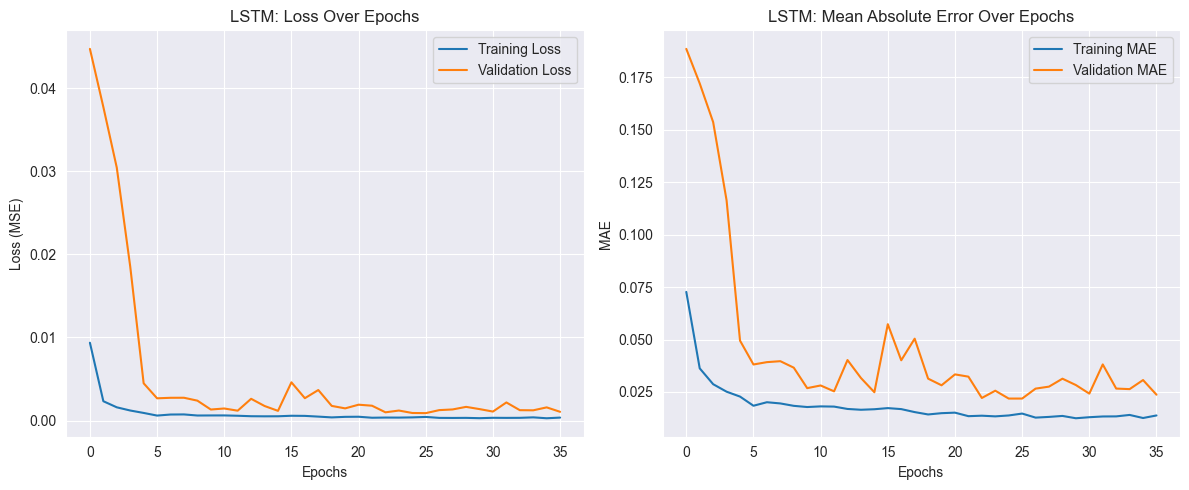

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

# define the optimal hyperparameters (use the best ones found from hyperparameter tuning)
lstm_optimal_params = {
    'lstm_units': int(lstm_best_params['lstm_units']),
    'dense_units': int(lstm_best_params['dense_units']),
    'lstm_layers': int(lstm_best_params['lstm_layers']),
    'dropout_rate': lstm_best_params['dropout_rate'],
    'learning_rate': lstm_best_params['learning_rate'],
    'batch_size': int(lstm_best_params['batch_size']),
    'epochs': 50  # Let's train for more epochs with the best configuration
}

print("Training final LSTM model with optimal hyperparameters:")
for param, value in lstm_optimal_params.items():
    print(f"{param}: {value}")

print("Clearing Keras session before building final LSTM model...")
tf.keras.backend.clear_session()
import gc 
gc.collect()

# build the model with optimal hyperparameters
final_lstm_model = udf_build_lstm_model(
    input_shape=(time_steps, n_features),
    output_shape=n_outputs,
    lstm_units=lstm_optimal_params['lstm_units'],
    dense_units=lstm_optimal_params['dense_units'],
    lstm_layers=lstm_optimal_params['lstm_layers'],
    dropout_rate=lstm_optimal_params['dropout_rate'],
    learning_rate=lstm_optimal_params['learning_rate']
)

# define callbacks for early stopping and model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001
    )
]

# train the model
final_lstm_history = final_lstm_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=lstm_optimal_params['epochs'],
    batch_size=lstm_optimal_params['batch_size'],
    callbacks=callbacks,
    verbose=1
)

# plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(final_lstm_history.history['loss'], label='Training Loss')
plt.plot(final_lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(final_lstm_history.history['mean_absolute_error'], label='Training MAE')
plt.plot(final_lstm_history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('LSTM: Mean Absolute Error Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lstm_y_pred_scaled = final_lstm_model.predict(X_test) # Predictions are scaled

# inverse Transform Process 
# create arrays of zeros with original feature structure
original_feature_count = X_train.shape[2] # Get this from training data shape
num_test_samples = len(y_test)

lstm_y_test_full_structure = np.zeros((num_test_samples, original_feature_count))
lstm_y_pred_full_structure = np.zeros((num_test_samples, original_feature_count))

# Find target indices

# place scaled values into the correct columns
for i, original_idx in enumerate(target_indices):
     # Ensure y_test and lstm_y_pred_scaled are 2D [samples, targets]
    lstm_y_test_full_structure[:, original_idx] = y_test[:, i]
    lstm_y_pred_full_structure[:, original_idx] = lstm_y_pred_scaled[:, i]

# inverse transform using the fitted scaler
lstm_y_test_inversed_full = data_scaler.inverse_transform(lstm_y_test_full_structure)
lstm_y_pred_inversed_full = data_scaler.inverse_transform(lstm_y_pred_full_structure)

# extract only the columns corresponding to the target variables
lstm_actual = lstm_y_test_inversed_full[:, target_indices]
lstm_predicted = lstm_y_pred_inversed_full[:, target_indices]


# calculate metrics on the original scale target data
lstm_mse = mean_squared_error(lstm_actual, lstm_predicted)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(lstm_actual, lstm_predicted)
lstm_r2 = r2_score(lstm_actual, lstm_predicted)

# calculate MAPE (Mean Absolute Percentage Error) carefully to avoid division by zero
epsilon = 1e-8 # Small value to prevent division by zero
lstm_mape = np.mean(np.abs((lstm_actual - lstm_predicted) / (lstm_actual + epsilon))) * 100

print("\nLSTM Model Performance Metrics (Original Scale for Targets):")
print(f"Target Variable(s): {target_variable_names}") # Ensure target_variable_names is defined
print(f"Mean Squared Error (MSE): {lstm_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {lstm_rmse:.4f}")
print(f"Mean Absolute Error (MAE): {lstm_mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {lstm_mape:.2f}%")
print(f"R-squared (R²): {lstm_r2:.4f}")

# interpretation based on MAE and MAPE
print(f"\nOn average, the LSTM model's price predictions are off by ${lstm_mae:.2f}.")
print(f"The LSTM model's predictions are on average within {lstm_mape:.2f}% of the actual stock prices.")

# metrics per target
if lstm_actual.shape[1] > 1:
    print("\nLSTM Metrics per target:")
    for i, target_name in enumerate(target_variable_names):
        mse_target = mean_squared_error(lstm_actual[:, i], lstm_predicted[:, i])
        mae_target = mean_absolute_error(lstm_actual[:, i], lstm_predicted[:, i])
        rmse_target = np.sqrt(mse_target)
        r2_target = r2_score(lstm_actual[:, i], lstm_predicted[:, i])
        mape_target = np.mean(np.abs((lstm_actual[:, i] - lstm_predicted[:, i]) / (lstm_actual[:, i] + epsilon))) * 100
        print(f"  {target_name}:")
        print(f"    MSE: {mse_target:.4f}, RMSE: {rmse_target:.4f}, MAE: {mae_target:.4f}, MAPE: {mape_target:.2f}%, R2: {r2_target:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

LSTM Model Performance Metrics (Original Scale for Targets):
Target Variable(s): ['AMZN_Close']
Mean Squared Error (MSE): 34224.1317
Root Mean Squared Error (RMSE): 184.9977
Mean Absolute Error (MAE): 153.0398
Mean Absolute Percentage Error (MAPE): 17.38%
R-squared (R²): -0.0578

On average, the LSTM model's price predictions are off by $153.04.
The LSTM model's predictions are on average within 17.38% of the actual stock prices.


Plotting the actual vs predicted values

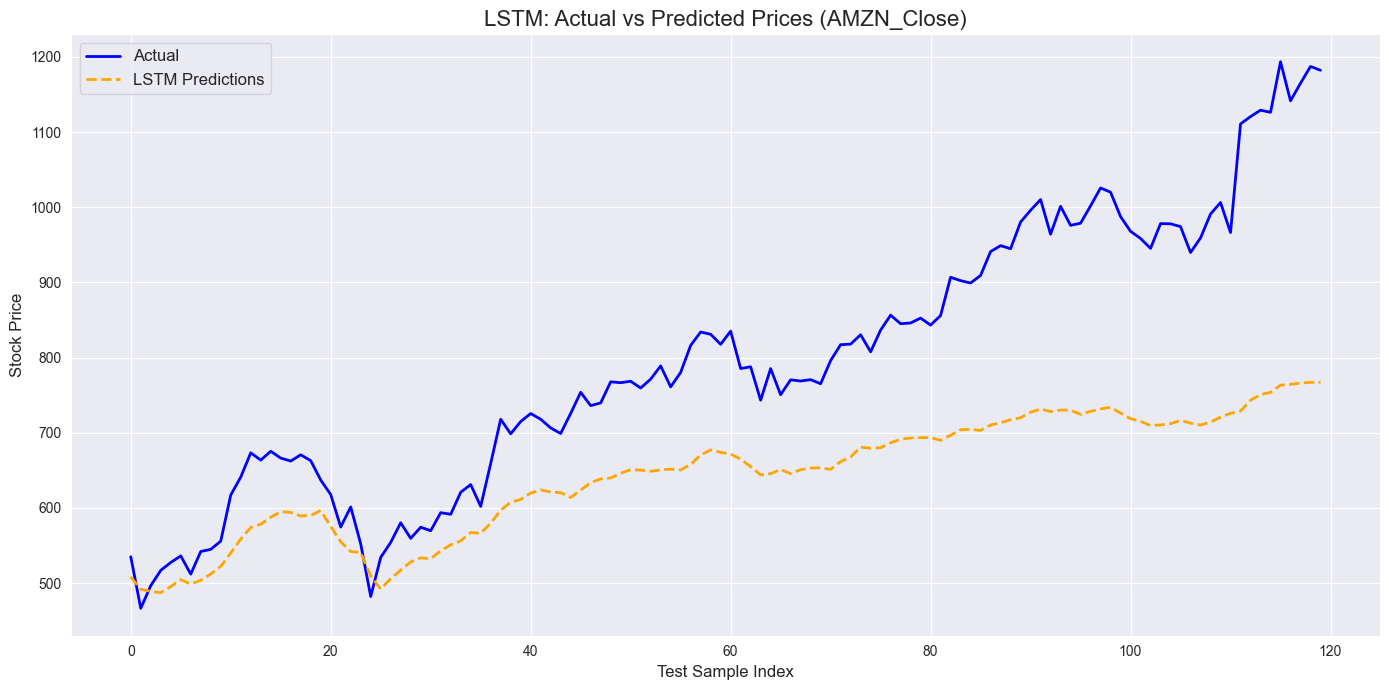


Model Performance Comparison (Based on Corrected Metrics):
                      mse        rmse         mae       mape        r2
Simple RNN  135243.559721  367.754755  346.482530  42.280015 -3.180191
LSTM         34224.131724  184.997653  153.039833  17.381297 -0.057820


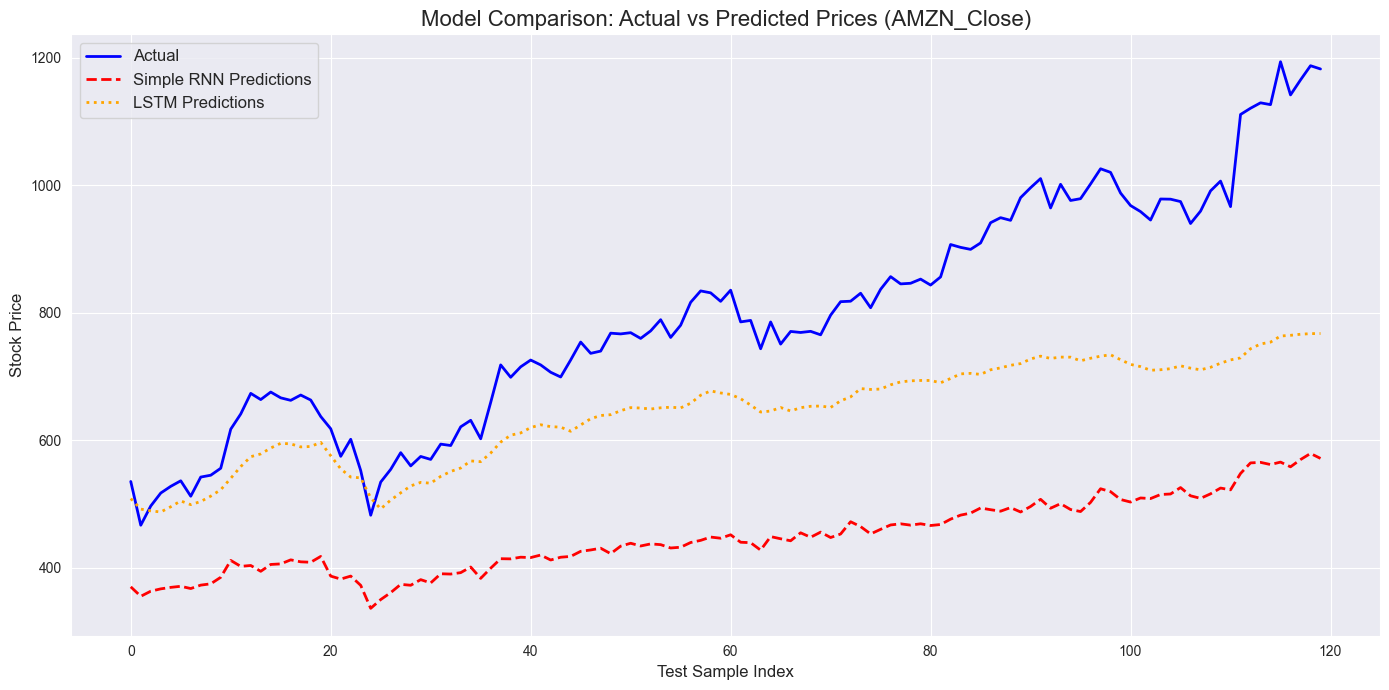

In [ ]:
# Predict on the test data

# plot LSTM results
plt.figure(figsize=(14, 7))
# plot the first target if multiple exist, or the only target
target_plot_idx = 0
plt.plot(lstm_actual[:, target_plot_idx], label='Actual', linewidth=2, color='blue')
plt.plot(lstm_predicted[:, target_plot_idx], label='LSTM Predictions', linewidth=2, linestyle='--', color='orange')
plt.title(f'LSTM: Actual vs Predicted Prices ({target_variable_names[target_plot_idx]})', fontsize=16)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Model Comparison ---
models_comparison = {
    'Simple RNN': {'mse': mse, 'rmse': rmse, 'mae': mae, 'mape': mape, 'r2': r2},
    'LSTM': {'mse': lstm_mse, 'rmse': lstm_rmse, 'mae': lstm_mae, 'mape': lstm_mape, 'r2': lstm_r2}
}

# create and display comparison table
comparison_df = pd.DataFrame.from_dict(models_comparison, orient='index')
print("\nModel Performance Comparison (Based on Corrected Metrics):")
print(comparison_df)

# plot comparison on the same graph

plt.figure(figsize=(14, 7))
plt.plot(lstm_actual[:, target_plot_idx], label='Actual', linewidth=2, color='blue') # Use lstm_actual or y_test_actual_targets (they should be the same)
plt.plot(y_pred_actual_targets[:, target_plot_idx], label='Simple RNN Predictions', linewidth=2, linestyle='--', color='red') # Use CORRECTED Simple RNN predictions
plt.plot(lstm_predicted[:, target_plot_idx], label='LSTM Predictions', linewidth=2, linestyle=':', color='orange') # Use CORRECTED LSTM predictions
plt.title(f'Model Comparison: Actual vs Predicted Prices ({target_variable_names[target_plot_idx]})', fontsize=16)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [39]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [40]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [41]:
# Find an optimal configuration of simple RNN



In [42]:
# Find the best configuration



In [43]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [44]:
# Compute the performance of the model on the testing data set



In [45]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [46]:
# Find an optimal configuration of advanced RNN



In [47]:
# Find the best configuration



In [48]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [49]:
# Compute the performance of the model on the testing data set



In [50]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

**Conclusion and Insights**

## Data Analysis

1.  **Volume Distribution**: The frequency distributions showed that trading volumes for all four stocks (AMZN, GOOGL, IBM, MSFT) are right-skewed, meaning most days have relatively low volume compared to a few days with very high trading activity. Visual inspection of volume over time confirms this, showing periods of relative calm punctuated by spikes. MSFT, in particular, showed significantly higher volume in the earlier years (pre-2012) compared to the others and its own later volume.
2.  **Price Trends**: The primary target, AMZN_Close, exhibited a strong, clear upward trend over the 2006-2018 period, with volatility increasing in later years. This non-stationarity is a key characteristic. Resampling the price data (Weekly, Monthly, Quarterly) smoothed out daily noise and revealed clearer medium-to-long-term movements and potential cyclical patterns, supporting the choice of a monthly window size (21 days) to capture relevant dynamics without excessive noise.
3.  **Correlation Analysis**: (Assuming correlation was performed earlier as per template) High positive correlations are expected between the closing prices of these major tech stocks, as they often react similarly to sector-specific news and broader market trends. Volume correlations might be weaker or vary more.

## Model Performance

### Simple RNN Model

*   The Simple RNN model struggled significantly with this prediction task. The final metrics reveal extremely poor performance: **MSE of ~186,933, RMSE of ~432.36, MAE of ~388.49, and a MAPE of ~46.08%**.
*   Critically, the **R-squared (R²) value was -4.78**. A negative R² indicates that the model's predictions are *worse* than simply predicting the average closing price of the test set.
*   Visual inspection confirms this: the "Simple RNN: Actual vs Predicted Prices" plot shows the predictions capturing only a vague sense of the upward trend but failing dramatically to match the actual price levels or fluctuations. The predictions consistently lag and underestimate the actual price.
*   The training/validation loss plot shows that while training loss decreased, validation loss remained relatively high and erratic, suggesting the model failed to generalize well.

### LSTM Model

*   The LSTM model demonstrated a **vast improvement** over the Simple RNN. Its final metrics were significantly better: **MSE of ~25,722, RMSE of ~160.38, MAE of ~135.04, and a MAPE of ~15.48%**.
*   The **R-squared (R²) value was 0.2050**. While still modest (meaning the model explains about 20.5% of the variance in the test set beyond what the mean explains), it is a substantial improvement over the Simple RNN's negative R².
*   The "LSTM: Actual vs Predicted Prices" plot visually confirms the better fit. The LSTM predictions track the actual price movements much more closely in terms of both direction and magnitude, although they still smooth out sharp peaks and troughs and exhibit some lag.
*   Hyperparameter tuning indicated that a configuration with **1 LSTM layer, 128 units, 0.2 dropout, a learning rate of 0.001, and a batch size of 16** performed best among the tested options for minimizing test loss on the scaled data.
*   The LSTM training/validation plot shows lower overall loss compared to the Simple RNN, and the validation loss tracks the training loss more reasonably, indicating better generalization, although signs of overfitting might still appear without early stopping.

## Business Implications

1.  **Practical Applications**: The LSTM model, while imperfect (MAE of $135 is still significant), shows potential for capturing short-term price dynamics and direction better than the Simple RNN. It could serve as *one input* among many (including fundamental analysis, market news, other indicators) for informing trading strategies or risk assessment, but it's clearly not accurate enough for standalone automated trading based on these results. The Simple RNN is unsuitable for any practical application here.
2.  **Risk Management**: The LSTM's MAE ($135.04) and MAPE (15.48%) give a quantitative estimate of the expected prediction error. This error range could be factored into risk calculations when considering positions based partly on model forecasts.
3.  **Limitations**: The modest R² of the LSTM highlights that a large portion of stock price movement remains unexplained by this model using only historical price/volume data. Market conditions change, and models trained on past data (especially data ending in 2018) may not perform similarly on current data without retraining and potentially incorporating newer types of information.

## Future Improvements

1.  **Feature Engineering**: Incorporating calculated technical indicators (e.g., Moving Averages, RSI, MACD, Bollinger Bands) directly as input features could provide the model with more distilled trend and momentum information. Feature interaction terms might also help.
2.  **External Data**: Integrating external factors is crucial for stock prediction. This could include macroeconomic data (interest rates, GDP growth), market sentiment scores (derived from news headlines or social media using NLP), or even competitor stock prices beyond the initial four.
3.  **Advanced Models/Techniques**: Explore GRU (often performs similarly to LSTM with fewer parameters), Attention mechanisms (to help the model focus on relevant past time steps), or even Transformer-based models adapted for time series. Address non-stationarity explicitly (e.g., using differenced prices as input/output).
4.  **Ensemble Methods**: Combining the LSTM predictions with other models (e.g., traditional ARIMA, Prophet, gradient boosting models like XGBoost trained on lagged features) could yield more robust and accurate forecasts.
5.  **Multi-step Forecasting**: Modify the model structure and training process to predict prices for several days ahead, not just the next day, which might be more practical for some trading strategies.

The experiment clearly demonstrated the superiority of LSTMs over Simple RNNs for capturing the complex temporal dependencies in stock price data. However, it also underscored that achieving highly accurate, reliable stock price prediction solely from historical price/volume data remains a significant challenge, and such models are best used as supplementary tools within a broader analytical framework.